In [ ]:
import numpy as np
import pandas, os, astropy, scipy, math
import matplotlib.pyplot as plt
import sklearn
from photutils.aperture import CircularAperture, SkyCircularAperture, aperture_photometry, EllipticalAperture, SkyEllipticalAperture
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.wcs.utils import pixel_to_skycoord
import astropy.io.fits as fits
from reproject import reproject_interp
import Real_code.img_scale as img_scale
from mpl_toolkits.axes_grid1 import Divider, Size
from astropy.cosmology import FlatLambdaCDM 
from astropy.wcs.utils import proj_plane_pixel_scales

# Load image, catalog

In [3]:
dist = 100 ## Mpc
target_pos = SkyCoord("12:57:00.9",
                      "27:31:55",
                      unit=(u.hourangle, u.deg))
target_skyaperture = SkyEllipticalAperture(target_pos, 
                                           15*u.arcsec, 
                                           15*u.arcsec, 
                                           0.*u.deg)

In [5]:
# AGC = 312297

# F475Wfitsname = f'HST/AGC{AGC}/dolphot/iemf15010_drc.chip1.fits'
# F814Wfitsname = f'HST/AGC{AGC}/dolphot/iemf15020_drc.chip1.fits'

F475Wfitsname ='/Users/ananthmugundhan/Documents/Research_work/Space_data/MAST-J9TY90040-drc/MAST_2025-09-23T23_15_52.467Z/HST/j9ty90040_drc.chip1.fits'
F814Wfitsname = '/Users/ananthmugundhan/Documents/Research_work/Space_data/MAST- J9TY90030-drc/MAST_2025-09-23T23_14_52.245Z/HST/j9ty90030_drc.chip1.fits'
E_B_V = 0.0084 #S&F2011
R_F475W = 3.268
R_F814W = 1.536
R_V = 2.742

In [6]:
full_cat = pandas.read_csv('/Users/ananthmugundhan/Documents/Research_work/SMDG1257009+273155_acs',delim_whitespace=True,header=None)
cut_cat = full_cat.iloc[:, :37].copy() ## Use Combined only (rest of them: individual chips)

header = np.genfromtxt('/Users/ananthmugundhan/Documents/Research_work/SMDG1257009+273155_acs.columns', dtype='U', delimiter="\n")
for i, line in enumerate(header):
    thisline = line.split('chip')
    if(len(thisline)>1): break ## We will keep columns w/o individual chip
        
header = header[:i]
Nfilter = (len(header)-11)/13

header_filter = np.zeros((len(header), 2), dtype=object)
for i, line in enumerate(header):
    thisline = line.split(',')
    header_filter[i,0]=line
    
    if(len(thisline)>1):
        if("F" in thisline[1]):
            header_filter[i]=thisline 

/var/folders/8r/91ycqry56d37cmtlkplyj96h0000gn/T/ipykernel_3675/2161973408.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  full_cat = pandas.read_csv('/Users/ananthmugundhan/Documents/Research_work/SMDG1257009+273155_acs',delim_whitespace=True,header=None)


In [7]:
cut_cat

0   1        2        3     4       5      6      7    8      9   ...  \
0       0   1  3832.94  2483.10  2.04  2011.1 -0.055  0.140   90  0.011  ...   
1       0   1  4109.17  3152.59  1.90  1973.1  0.017  0.054  100  0.019  ...   
2       0   1  2865.74    78.51  2.60  1159.3  0.005  0.040  100  0.009  ...   
3       0   1  2918.91    70.88  0.00    45.3  3.016  0.302   10  0.000  ...   
4       0   1  2632.50    64.75  0.00    56.4 -9.999  0.701   75  0.000  ...   
...    ..  ..      ...      ...   ...     ...    ...    ...  ...    ...  ...   
87364   0   1  2654.93  1268.93  0.99     5.5  0.004  6.517   90  0.020  ...   
87365   0   1  2164.57  4019.97  1.03     5.2 -0.016  0.176   10  0.144  ...   
87366   0   1  1344.38  2296.85  1.25     5.6 -0.107  1.466   15  0.005  ...   
87367   0   1  3214.09  3295.71  0.83     5.4 -0.038  0.656   35  0.021  ...   
87368   0   1   256.57  2975.43  1.05     4.0 -0.088  2.339  105  0.099  ...   

                 27      28      29     30    31     32     33     34     35  \
0      9.999000e+03  99.999  99.999  9.999  0.00    0.0  0.000  0.000  0.000   
1      9.999000e+03  99.999  99.999  9.999  0.00    0.0  0.000  0.000  0.000   
2      8.400000e-11  18.038  99.999  0.001  2.29  725.4  0.014  0.042  0.004   
3      9.999000e+03  99.999  99.999  9.999  0.00    0.0  0.000  0.000  0.000   
4      9.999000e+03  99.999  99.999  9.999  0.00    0.0  0.000  0.000  0.000   
...             ...     ...     ...    ...   ...    ...    ...    ...    ...   
87364  8.930000e-13  29.729  29.730  0.756  1.22    1.4  0.065  6.787  0.068   
87365  3.670000e-12  31.208  31.200  9.999  0.98    0.1 -0.125 -0.039  0.015   
87366  2.060000e-12  28.572  28.564  0.601  0.80    1.8 -0.144  5.959  0.008   
87367  1.930000e-12  28.056  28.142  0.349  0.93    3.1 -0.131 -0.100  0.035   
87368  3.430000e-12  30.829  30.788  7.986  1.01    0.1  0.704 -0.077  0.199   

       36  
0       0  
1       0  
2       0  
3       0  
4       0  
...    ..  
87364   0  
87365   0  
87366   0  
87367   0  
87368   0  

[87369 rows x 37 columns]

In [8]:
header_filter

array([[np.str_('1. Extension (zero for base image)'), 0],
       [np.str_('2. Chip (for three-dimensional FITS image)'), 0],
       [np.str_('3. Object X position on reference image (or first image, if no reference)'),
        0],
       [np.str_('4. Object Y position on reference image (or first image, if no reference)'),
        0],
       [np.str_('5. Chi for fit'), 0],
       [np.str_('6. Signal-to-noise'), 0],
       [np.str_('7. Object sharpness'), 0],
       [np.str_('8. Object roundness'), 0],
       [np.str_('9. Direction of major axis (if not round)'), 0],
       [np.str_('10. Crowding'), 0],
       [np.str_('11. Object type (1=bright star, 2=faint, 3=elongated, 4=hot pixel, 5=extended)'),
        0],
       ['12. Total counts', ' ACS_F475W'],
       ['13. Total sky level', ' ACS_F475W'],
       ['14. Normalized count rate', ' ACS_F475W'],
       ['15. Normalized count rate uncertainty', ' ACS_F475W'],
       ['16. Instrumental VEGAMAG magnitude', ' ACS_F475W'],
       ['17.

# Image

In [9]:
F475Wfits = fits.open(F475Wfitsname)
F475W = F475Wfits[0].data
F475Wheader = F475Wfits[0].header
F814Wfits = fits.open(F814Wfitsname)
F814W = F814Wfits[0].data
F814Wheader = F814Wfits[0].header

HST_projection = WCS(F814Wheader)
target_aperture = target_skyaperture.to_pixel(HST_projection)

In [10]:
HST_projection
F475Wfits[0].header

SIMPLE  =                    T / Standard FITS format                           
BITPIX  =                  -32 / Data type                                      
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 4226 /                                                
NAXIS2  =                 4300 /                                                
EXTEND  =                    F / There are no standard extensions               
BSCALE  =             1.000000 / Image scale                                    
BZERO   =             0.000000 / Image zero                                     
DATE    = '2025-08-02'         / date this file was written (yyyy-mm-dd)        
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
                                                                                
TELESCOP= 'HST'             

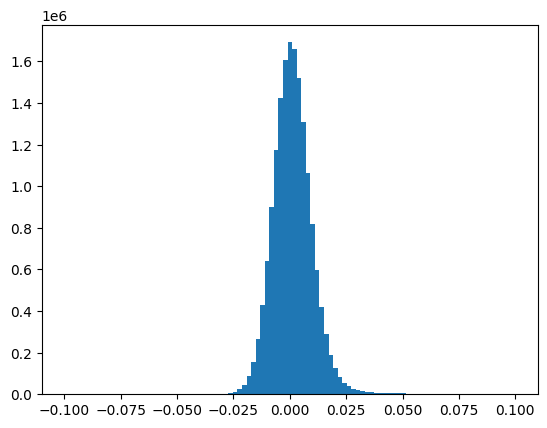

In [11]:
plt.hist(F814W.ravel(), np.linspace(-0.1, 0.1, 100))
plt.show()

Text(0, 0.5, 'Y position')

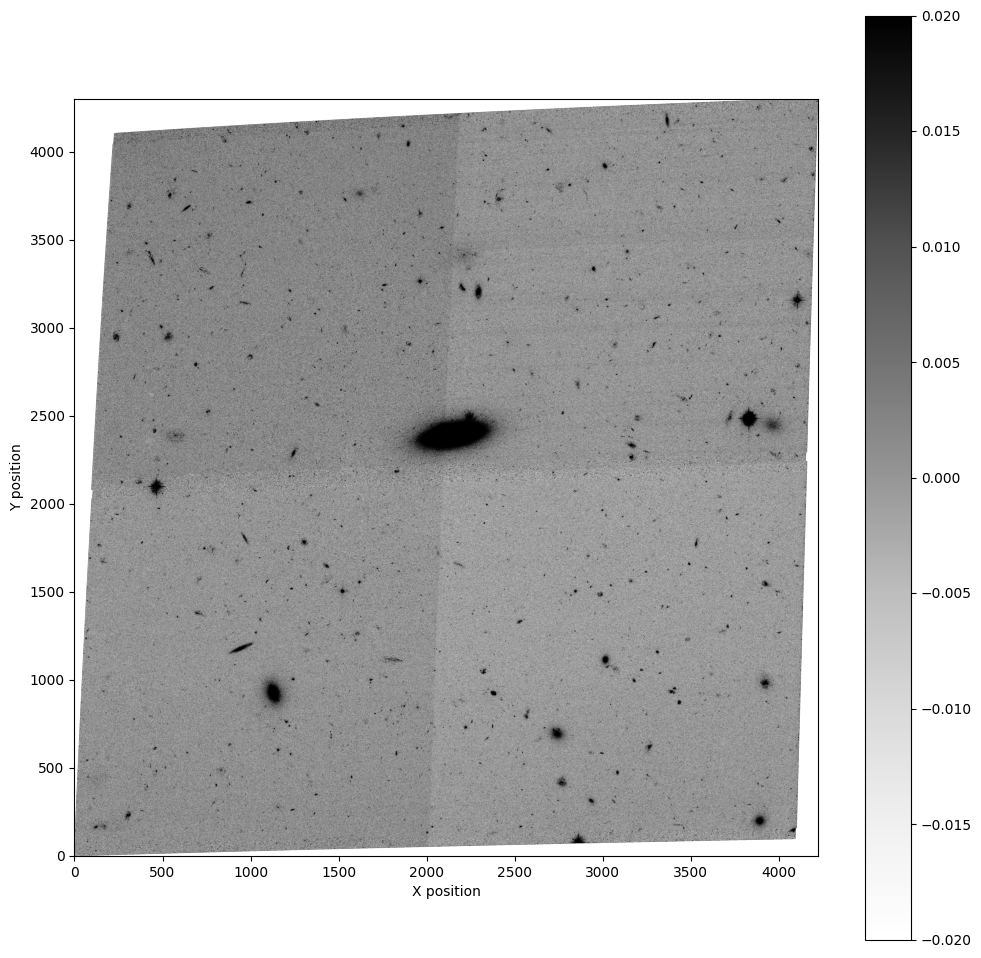

In [12]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(F475W, origin='lower', cmap='Greys', vmin=-0.020, vmax=0.020)
plt.colorbar()

plt.xlabel(r'X position')
plt.ylabel(r'Y position')

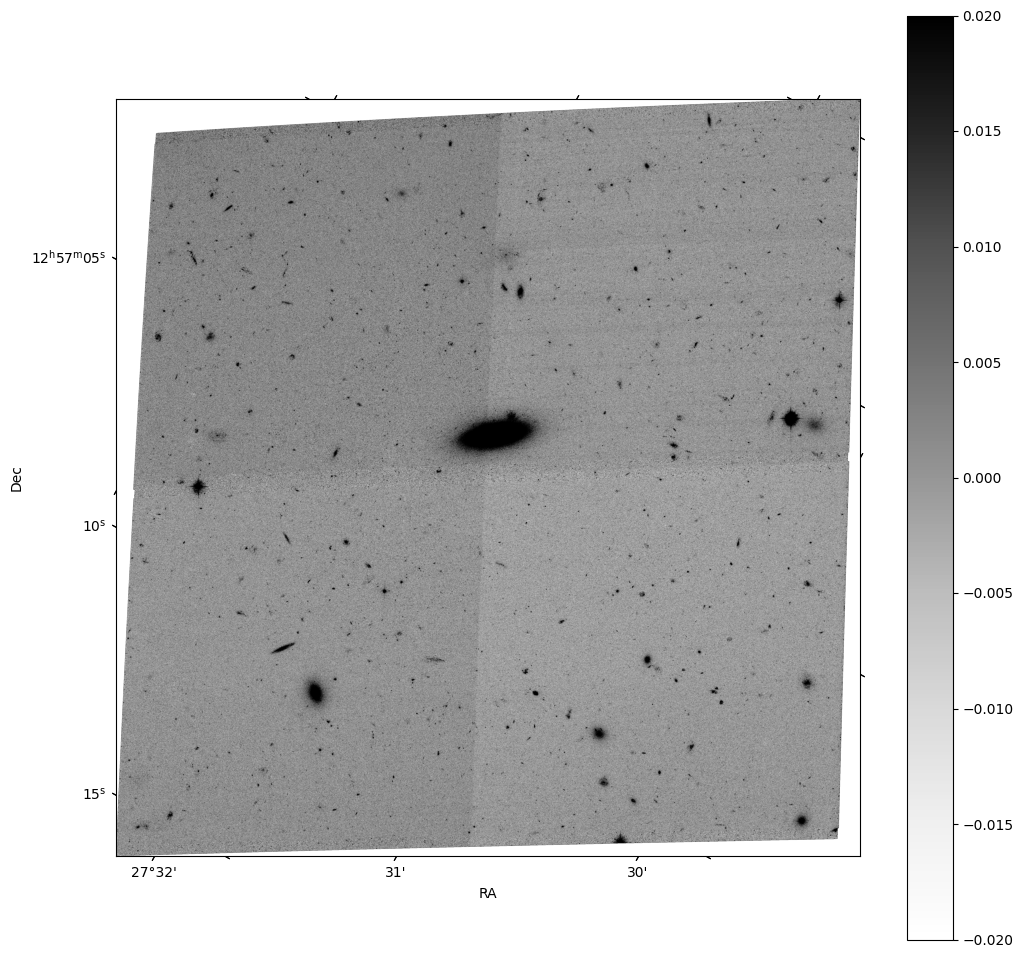

In [13]:
fig = plt.figure(figsize=(12, 12))
plt.subplot(projection=HST_projection)
plt.imshow(F475W, origin='lower', cmap='Greys', vmin=-0.020, vmax=0.020)
plt.colorbar()

plt.xlabel(r'RA')
plt.ylabel(r'Dec')

In [14]:
np.shape(F475W), np.shape(F814W)

((4300, 4226), (4300, 4226))

In [15]:
WCS(F475Wheader)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 194.27169476162956 27.524840765797602 
CRPIX : 2113.0 2150.0 
CD1_1 CD1_2  : -6.7541430218742e-06 -1.2136011972965e-05 
CD2_1 CD2_2  : -1.2136011972965e-05 6.75414302187423e-06 
NAXIS : 4226  4300

In [16]:
F475W, footprint = reproject_interp((F475W,WCS(F475Wheader)), HST_projection, 
                                    shape_out=[F814W.shape[0], F814W.shape[1]])

HST_RGB_img = np.zeros((F814W.shape[0], F814W.shape[1], 3), dtype=float)
HST_RGB_img[:,:,0] = img_scale.linear(F814W, scale_min=0, scale_max=0.020)
HST_RGB_img[:,:,1] = img_scale.linear((F814W+F475W)/2., scale_min=0, scale_max=0.020)
HST_RGB_img[:,:,2] = img_scale.linear(F475W, scale_min=0, scale_max=0.020)

HST_RGB_img[:,:,0] = scipy.ndimage.gaussian_filter(HST_RGB_img[:,:,0],1.5,mode='wrap')
HST_RGB_img[:,:,1] = scipy.ndimage.gaussian_filter(HST_RGB_img[:,:,1],1.5,mode='wrap')
HST_RGB_img[:,:,2] = scipy.ndimage.gaussian_filter(HST_RGB_img[:,:,2],1.5,mode='wrap')

img_scale : linear
img_scale : linear
img_scale : linear


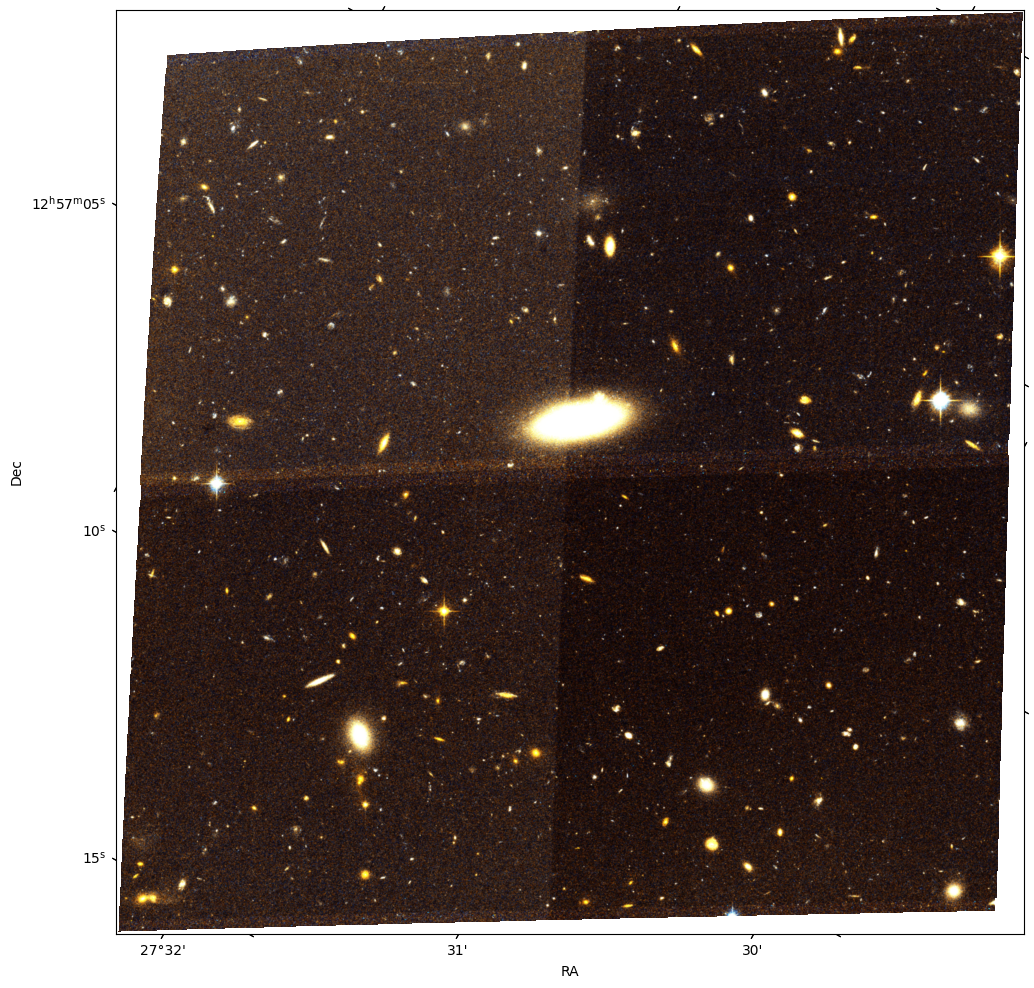

In [17]:
fig = plt.figure(figsize=(12, 12))
plt.subplot(projection=HST_projection)
plt.imshow(HST_RGB_img, origin='lower', cmap='Greys', aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

# Cut objects

In [18]:
max_mag = 30.  # Maxmum mag (Telescope cut)
snr_thresh = 3.  # For nearby, 5
crowd_thresh = 0.5 #[mag], Normal cut  
sharp_thresh = 0.25 #Normal cut  defraction spikes
round_thresh = 3.  #Weak constraint (elongated)

## Instrumental VEGAMAG magnitude cut
print(f"Total dolphot catalogue length: {len(full_cat)}")
print(f"Require: mag < {max_mag} (in both filters)")
condition = (cut_cat[15] < max_mag) & (cut_cat[28] < max_mag)
sub_cat = cut_cat[condition]
print(f"New catalogue length: {len(sub_cat)}")

## Object Type cut
print("Remove sources that are not type point-like.")
condition = (sub_cat[10] <= 2)
sub_cat = sub_cat[condition]
print(f"New catalogue length: {len(sub_cat)}")

## Photometry quality flag cut
print("Remove sources that have flag != 0 (in either filter).")
condition = (sub_cat[23] == 0) & (sub_cat[36] == 0)
sub_cat = sub_cat[condition]
print(f"New catalogue length: {len(sub_cat)}")

## SNR cut
print(f"Require: S/N > {snr_thresh} (in both filters).")
condition = (sub_cat[19] > snr_thresh) & (sub_cat[32] > snr_thresh)
sub_cat = sub_cat[condition]
print(f"New catalogue length: {len(sub_cat)}")

## Crowding cut
print(f"Require: crowding < {crowd_thresh} mag.")
condition = (sub_cat[22] + sub_cat[35] < crowd_thresh)
sub_cat = sub_cat[condition]
print(f"New catalogue length: {len(sub_cat)}")

## Sharpness cut 
print(f"Require: absolute sharpness < {sharp_thresh} (in both filters).")
condition = (np.absolute(sub_cat[20]) < sharp_thresh) & (np.absolute(sub_cat[33]) < sharp_thresh)
sub_cat = sub_cat[condition]
print(f"New catalogue length: {len(sub_cat)}")

## Roundness cut
print(f"Require: roundness < {round_thresh} (in both filters).")
condition = (sub_cat[21]  < round_thresh) & (sub_cat[34] < round_thresh)
sub_cat = sub_cat[condition]
print(f"New catalogue length: {len(sub_cat)}")

Total dolphot catalogue length: 87369
Require: mag < 30.0 (in both filters)
New catalogue length: 33596
Remove sources that are not type point-like.
New catalogue length: 32162
Remove sources that have flag != 0 (in either filter).
New catalogue length: 24529
Require: S/N > 3.0 (in both filters).
New catalogue length: 4368
Require: crowding < 0.5 mag.
New catalogue length: 2280
Require: absolute sharpness < 0.25 (in both filters).
New catalogue length: 935
Require: roundness < 3.0 (in both filters).
New catalogue length: 933


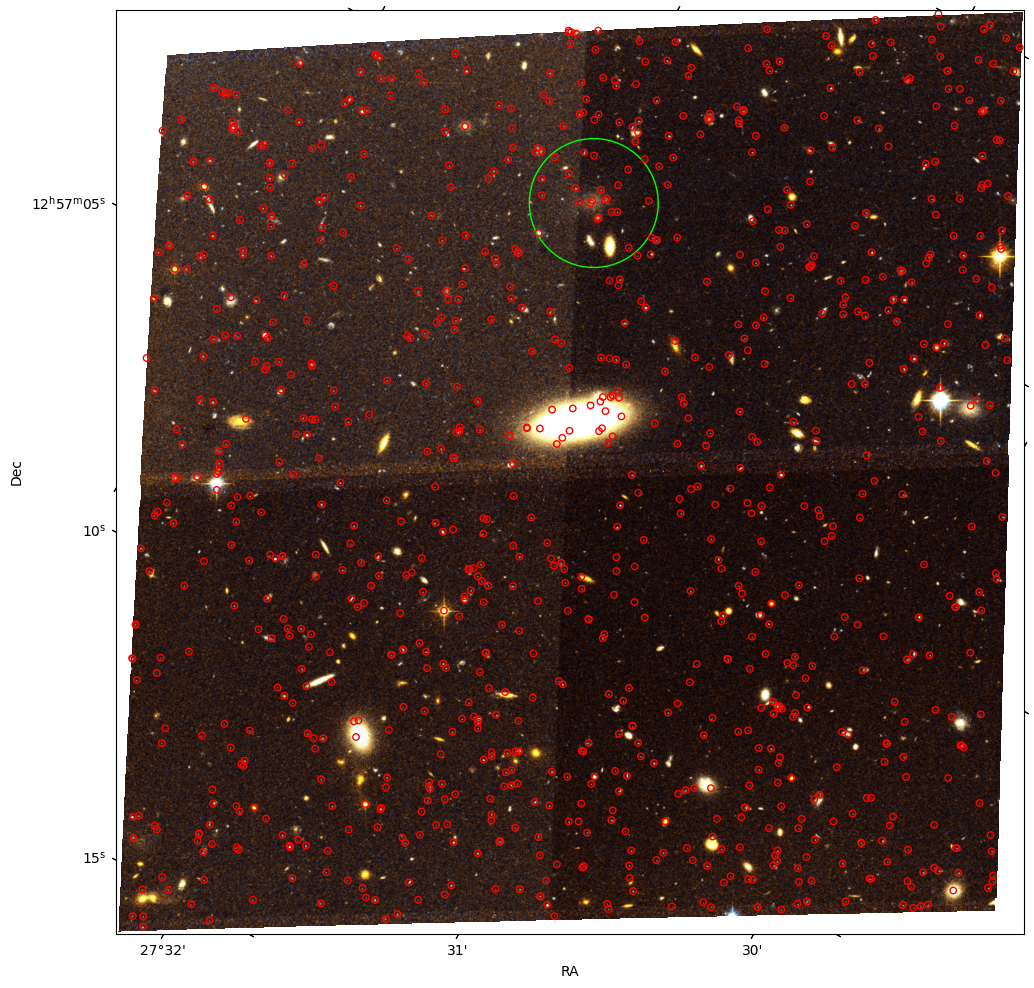

In [19]:
positions = np.transpose([np.array(sub_cat[2]), np.array(sub_cat[3])])
apertures = CircularAperture(positions, r=15.)

fig = plt.figure(figsize=(12, 12))
plt.subplot(projection=HST_projection)
plt.imshow(HST_RGB_img, origin='lower', cmap='Greys', aspect='equal')

target_aperture.plot(color='lime')

apertures.plot(color='r')

plt.xlabel(r'RA')
plt.ylabel(r'Dec')

(2898.928624747107, 3898.928624747107)

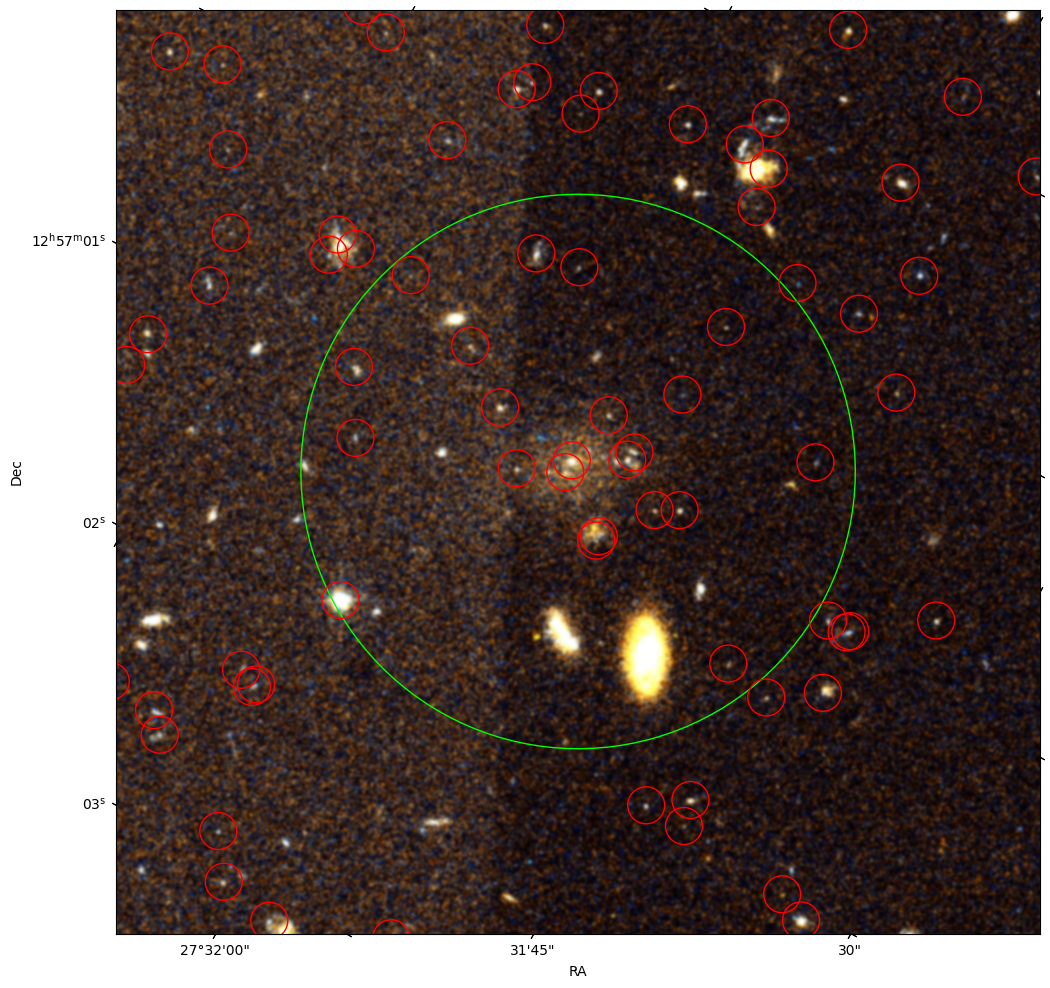

In [20]:
padding=500
positions = np.transpose([np.array(sub_cat[2]), np.array(sub_cat[3])])
apertures = CircularAperture(positions, r=20.)

fig = plt.figure(figsize=(12, 12))
plt.subplot(projection=HST_projection)
plt.imshow(HST_RGB_img, origin='lower', cmap='Greys', aspect='equal')

target_aperture.plot(color='lime')

apertures.plot(color='r')

plt.xlabel(r'RA')
plt.ylabel(r'Dec')

plt.xlim(target_aperture.positions[0]-padding, target_aperture.positions[0]+padding)
plt.ylim(target_aperture.positions[1]-padding, target_aperture.positions[1]+padding)
#angular diamater distance

In [21]:
x_position = np.array(sub_cat[2])
y_position = np.array(sub_cat[3])

In [22]:
distances = []
for i in range(len(x_position)):
    a = x_position[i]
    b = y_position[i]
    skycoord1 = HST_projection.pixel_to_world(a,b)
    ang_diff = skycoord1.separation(target_pos)
    distances.append(ang_diff.arcsec)
distances = np.array(distances)
distances # all the distances in a numpy array
x_position, y_position # x and y positions in numpy array


(array([1525.19,  272.92, 1965.4 , 1159.44, 1621.33,  271.57, 1145.03,
        2005.95, 3711.45,  410.68, 2721.45,  889.14, 1570.74, 3895.11,
        3666.99,  449.93, 2463.78, 2555.09, 3141.73, 3093.43,  740.64,
        3048.76,  642.94, 3407.29, 2345.15, 1042.78,  692.73, 3515.26,
        2215.74,  684.79,  539.82, 2502.12, 2276.92,  547.92, 3323.53,
         851.14,  782.84, 3047.08,  715.3 , 2156.01, 4114.01, 3086.68,
        1535.67, 1307.6 , 1520.32, 1559.1 , 2405.51, 1596.79,  808.71,
        2705.56, 3682.41, 1461.  , 3941.32,  623.57, 3816.89,  589.89,
        1878.9 , 2244.85, 2571.49,  197.9 , 3919.2 , 3785.04,  438.03,
         909.11,  451.06,  545.49,  266.64, 2018.54, 1521.75, 4175.79,
        2014.97, 2138.08,  809.21, 3177.07, 2399.69,  174.3 , 1230.  ,
         956.08, 1876.57, 1709.5 , 2332.43, 4056.76, 2226.57, 1564.51,
        3138.48, 1640.82, 1609.56, 2275.72, 3239.54, 2341.27, 3850.83,
        3661.05, 1685.08, 2387.13, 2377.3 , 2514.76, 3934.02, 2816.48,
      

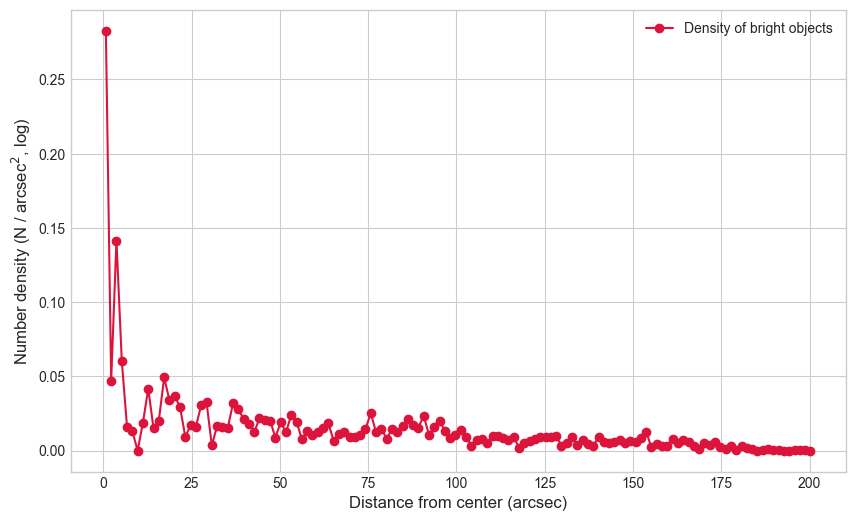

[0.28294212 0.04715702 0.14147106 0.06063045 0.01571901 0.01286101
 0.         0.01886281 0.04160914 0.01489169 0.02021015 0.04920733
 0.03395305 0.03667768 0.02926987 0.00912717 0.01714801 0.01616812
 0.03058834 0.03264717 0.00345051 0.01645012 0.01571901 0.01505011
 0.03175881 0.02773942 0.02135412 0.01800541 0.01240974 0.02158033
 0.02087278 0.02021015 0.00870591 0.01900358 0.01230183 0.0239106
 0.0193796  0.00754512 0.01286101 0.01074464 0.01222589 0.01534024
 0.01830802 0.00650442 0.01112694 0.01243702 0.00912717 0.00893501
 0.01020925 0.01429001 0.02521266 0.01236155 0.01482078 0.00793296
 0.0142769  0.01274514 0.01627543 0.02091311 0.01692816 0.01545482
 0.02338365 0.01035154 0.01584476 0.02005102 0.0131601  0.00863945
 0.01063692 0.01362314 0.00929372 0.00305333 0.00702339 0.00791446
 0.00487831 0.00962388 0.0094947  0.00843205 0.00739718 0.00912717
 0.00180218 0.00533853 0.00615092 0.00781129 0.0094314  0.00931845
 0.00920818 0.00992779 0.00327101 0.00485044 0.00879199 0.00395

In [50]:
max_radius = 200
bin_width = 1.5
filtered_distances = distances[distances <= max_radius]
bin_edges = np.arange(0, max_radius + bin_width, bin_width)
counts, _ = np.histogram(filtered_distances, bins=bin_edges)
ring_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
number_density = np.divide(counts, ring_areas, out=np.zeros_like(counts, dtype=float), where=ring_areas!=0)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
valid_points_mask = number_density > 0
x_to_fit = bin_centers[valid_points_mask]
y_to_fit_log = np.log10(number_density[valid_points_mask])
slope, intercept = np.polyfit(x_to_fit, y_to_fit_log, 1)
log_fit_line = slope * x_to_fit + intercept
fit_line_linear = 10**log_fit_line

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, number_density, 'o-', color='crimson', label='Density of bright objects')
#plt.plot(x_to_fit, fit_line_linear, '--', color='navy', label=f'Line of best fit (slope={slope:.2f})')
#plt.yscale('log')
#plt.errorbar(bin_centers, number_density, yerr=np.sqrt(counts)/ring_areas, fmt='o', color='crimson', alpha=0.5)
plt.xlabel(r'Distance from center (arcsec)', fontsize=12)
plt.ylabel(r'Number density (N / arcsec$^2$, log)', fontsize=12)
plt.legend()
plt.show()
print(number_density)

In [24]:
0.023997 

0.023997

In [ ]:
def get_physical_scale(redshift):
    """
    Calculates the angular diameter distance and physical scale (kpc/arcsec)
    for a given redshift using a standard cosmological model.

    Args:
        redshift (float): The redshift (z) of the target galaxy.

    Returns:
        float: The physical scale in kiloparsecs per arcsecond.
    """
    # --- 1. Define a Cosmological Model ---
    # We will use the standard "Planck 2018" cosmology.
    cosmo = FlatLambdaCDM(H0=67.7, Om0=0.31)
    
    # --- 2. Calculate Angular Diameter Distance ---
    # This returns an astropy Quantity object (a value with a unit, e.g., Mpc).
    angular_diameter_dist = cosmo.angular_diameter_distance(redshift)
    luminosity_distance = cosmo.luminosity_distance(redshift)
    
    print(f"For a redshift of z = {redshift}:")
    print(f"The Angular Diameter Distance is: {angular_diameter_dist:.2f}")

    # --- 3. Calculate the Physical Scale (kpc/arcsec) [CORRECTED METHOD] ---
    # This method correctly handles the units to avoid the conversion error.
    
    # First, get the numerical value of 1 arcsecond in units of radians.
    one_arcsec_in_radians = (1 * u.arcsec).to_value(u.rad)
    
    # Use the small-angle formula: Physical Size = Angle (as a number) * Distance (as a Quantity)
    # This correctly results in a new Quantity with units of distance (Mpc).
    physical_size_at_dist = one_arcsec_in_radians * angular_diameter_dist
    
    # The result 'physical_size_at_dist' is a Quantity in Mpc.
    # We now convert it to our desired final unit of kiloparsecs (kpc).
    scale_in_kpc = physical_size_at_dist.to(u.kpc)
    
    # Finally, we extract the plain numerical value from the Quantity object.
    scale_kpc_per_arcsec = scale_in_kpc.value
    
    print(f"The physical scale at this distance is: {scale_kpc_per_arcsec:.4f} kpc / arcsecond")
    
    return scale_kpc_per_arcsec

scale = get_physical_scale(0.023997)  

print(scale)




For a redshift of z = 0.023997:
The Angular Diameter Distance is: 103.19 Mpc
The physical scale at this distance is: 0.5003 kpc / arcsecond
0.5002923895250218


In [26]:
distances_kpc = scale * distances
distances_kpc

array([50.55739286, 49.36890704,  7.31175576, 74.85415598, 48.54355829,
       58.32879253, 28.99555748, 81.8623889 , 41.406396  , 45.36326512,
       33.02082067, 42.88553324, 76.16050783, 90.30709011, 37.8424    ,
       44.50116264, 13.56933174, 72.47857938, 70.75765297, 38.3975563 ,
       55.53553727, 50.97638625, 80.68246652, 68.6334618 , 35.29782537,
       43.93363171, 41.25468809, 32.84319418,  0.34689987, 38.47013849,
       42.96652031, 65.5572331 , 24.2628227 , 42.82802819, 30.61832564,
       35.58121212, 67.71813964, 66.77101057, 37.81580583, 10.48316626,
       47.57738155, 27.19194064, 56.78778331, 85.89178208, 42.09333771,
       81.13832778, 80.21948091, 30.85978786, 82.91376088, 35.124781  ,
       39.2186115 , 70.81786769, 43.42239446, 52.55128738, 43.27971524,
       41.28129695, 80.33678141, 10.31694541, 11.72134401, 50.96748366,
       88.76816893, 65.56695805, 44.91099967, 37.79860003, 49.98916263,
       42.84525089, 61.48875113, 15.97273829, 56.40385277, 51.21

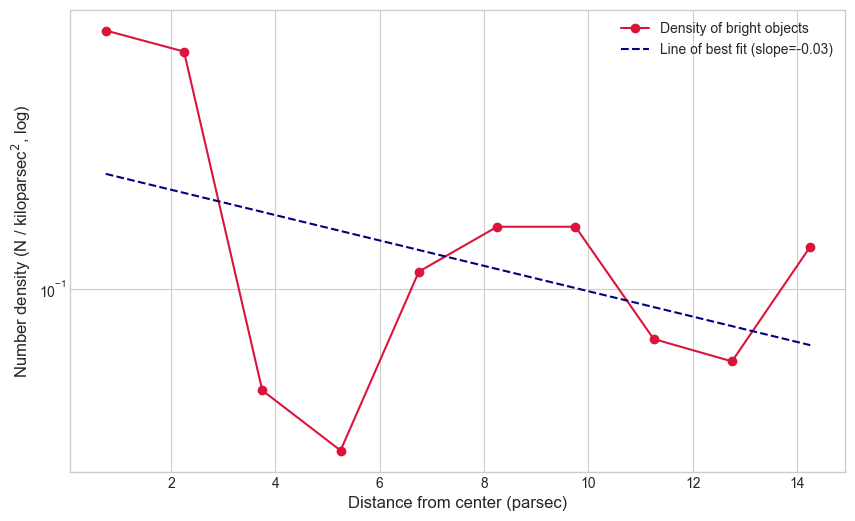

array([ 7.31175576, 13.56933174,  0.34689987, 10.48316626, 10.31694541,
       11.72134401,  2.73414335,  2.94171106,  1.36934089,  9.85969246,
       14.01345964, 10.49918739,  6.01113779,  9.3988014 , 13.893996  ,
       14.42977102, 12.12149904,  1.65954343, 10.61224551, 10.64818286,
       10.89972945,  1.73115719,  0.3476142 ,  2.31929884,  9.94037716,
       14.6749361 , 14.75698132, 12.70934046,  9.22267198,  9.68427789,
        9.14149051, 14.76405335,  1.61270992, 11.17595446,  8.54367788,
       14.09882745, 13.77049816,  8.72204233, 13.61194693, 13.38157545,
        8.47205542,  1.83900699, 13.17278914,  4.48583801, 14.63355596,
        8.93467107,  6.09496335,  7.96139697,  5.53111892,  6.69351594,
        5.59930806,  9.64608914,  7.87925111, 12.87565253,  6.43272762,
       12.22109766,  8.87502571, 11.41241974,  8.94209236, 12.97769989,
       10.44873116,  7.83028199, 14.67749418, 13.89020235, 10.01590439,
        1.93367396,  6.98245945, 10.58265597, 14.64111841,  9.68

In [51]:
max_radius = 15
bin_width = 1.5
filtered_distances = distances_kpc[distances_kpc <= max_radius]
bin_edges = np.arange(0, max_radius + bin_width, bin_width)
counts, _ = np.histogram(filtered_distances, bins=bin_edges)
ring_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
number_density = np.divide(counts, ring_areas, out=np.zeros_like(counts, dtype=float), where=ring_areas!=0)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
valid_points_mask = number_density > 0
x_to_fit = bin_centers[valid_points_mask]
y_to_fit_log = np.log10(number_density[valid_points_mask])
slope, intercept = np.polyfit(x_to_fit, y_to_fit_log, 1)
log_fit_line = slope * x_to_fit + intercept
fit_line_linear = 10**log_fit_line

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, number_density, 'o-', color='crimson', label='Density of bright objects')
plt.plot(x_to_fit, fit_line_linear, '--', color='navy', label=f'Line of best fit (slope={slope:.2f})')
plt.yscale('log')
#plt.errorbar(bin_centers, number_density, yerr=np.sqrt(counts)/ring_areas, fmt='o', color='crimson', alpha=0.5)
plt.xlabel(r'Distance from center (parsec)', fontsize=12)
plt.ylabel(r'Number density (N / kiloparsec$^2$, log)', fontsize=12)
plt.legend()
plt.show()

filtered_distances

In [28]:
UDG_centre = HST_projection.world_to_pixel(target_pos)
print(np.array(UDG_centre))

[2222.51310775 3398.92862475]


In [ ]:
max_radius_arcsec = 165.0
bin_width_arcsec = 1.5

clean_phot_table = sub_cat[~np.isnan(sub_cat[2]) & ~np.isnan(sub_cat[3])]


In [30]:
pixel_scales = proj_plane_pixel_scales(HST_projection)
pixel_scale_arcsec = (pixel_scales[0] + pixel_scales[1]) / 2.0 * 3600.0

max_radius_pixels = max_radius_arcsec / pixel_scale_arcsec
bin_width_pixels = bin_width_arcsec / pixel_scale_arcsec

In [45]:
x_positions = clean_phot_table[2].values
y_positions = clean_phot_table[3].values

distances_pixels = np.sqrt((x_positions - UDG_centre[0])**2 + (y_positions - UDG_centre[1])**2)

filtered_distances = distances_pixels[distances_pixels <= max_radius_pixels]

bin_edges = np.arange(0, max_radius_pixels + bin_width_pixels, bin_width_pixels)

counts, _ = np.histogram(filtered_distances, bins=bin_edges)

ring_areas_pixels2 = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)

number_density_pixels = np.divide(counts, ring_areas_pixels2, out=np.zeros_like(counts, dtype=float), where=ring_areas_pixels2!=0)
bin_centers_pixels = (bin_edges[1:] + bin_edges[:-1]) / 2

In [48]:
# Choose the image to use for the NaN mask (e.g. F814W; HST_RGB_img[:,:,0] also works)
img = F814W

# grid of pixel coordinates and radial distance from UDG center (pixels)
yy, xx = np.indices(img.shape)
rgrid = np.sqrt((xx - UDG_centre[0])**2 + (yy - UDG_centre[1])**2)

# compute corrected area = number of valid (non-NaN) pixels in each annulus
corrected_ring_area_pixels2 = np.zeros(len(bin_edges)-1, dtype=float)
for i in range(len(bin_edges)-1):
    inner, outer = bin_edges[i], bin_edges[i+1]
    ann_mask = (rgrid >= inner) & (rgrid < outer) & (~np.isnan(img))
    corrected_ring_area_pixels2[i] = ann_mask.sum()  # pixels

# corrected number density (sources per valid pixel)
number_density_pixels_corrected = np.divide(
    counts, corrected_ring_area_pixels2,
    out=np.zeros_like(counts, dtype=float), where=corrected_ring_area_pixels2!=0
)

print("geometric areas (first 6):", ring_areas_pixels2[:6])
print("valid-pixel areas (first 6):", corrected_ring_area_pixels2[:6])
print("orig density (first 6):", number_density_pixels[:6])
print("corrected density (first 6):", number_density_pixels_corrected[:6])

geometric areas (first 6): [ 2827.43338823  8482.30016469 14137.16694115 19792.03371762
 25446.90049408 31101.76727054]
valid-pixel areas (first 6): [ 2822.  8495. 14126. 19793. 25460. 31082.]
orig density (first 6): [7.07355303e-04 1.17892550e-04 3.53677651e-04 1.51576136e-04
 3.92975168e-05 3.21525138e-05]
corrected density (first 6): [7.08717222e-04 1.17716304e-04 3.53957242e-04 1.51568736e-04
 3.92772977e-05 3.21729618e-05]


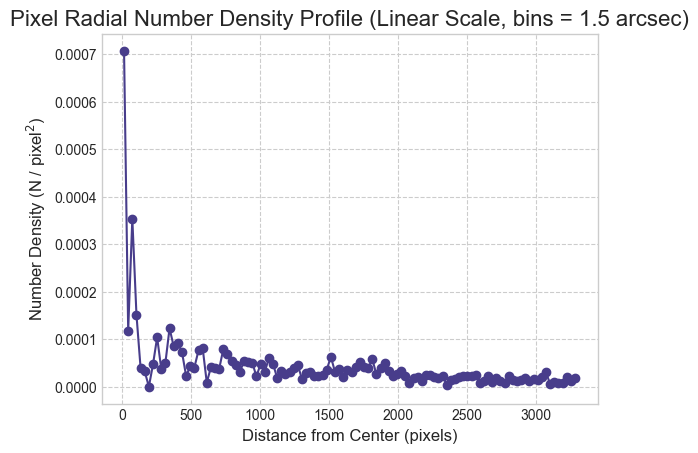

In [32]:
plt.plot(bin_centers_pixels, number_density_pixels, 'o-', color='darkslateblue')

plt.title(f'Pixel Radial Number Density Profile (Linear Scale, bins = {bin_width_arcsec:.1f} arcsec)', fontsize=16)
plt.xlabel(r'Distance from Center (pixels)', fontsize=12)
plt.ylabel(r'Number Density (N / pixel$^2$)', fontsize=12)
plt.grid(True, which="both", ls="--")
plt.show()

In [33]:
print(bin_centers_pixels, number_density_pixels)

[  15.   45.   75.  105.  135.  165.  195.  225.  255.  285.  315.  345.
  375.  405.  435.  465.  495.  525.  555.  585.  615.  645.  675.  705.
  735.  765.  795.  825.  855.  885.  915.  945.  975. 1005. 1035. 1065.
 1095. 1125. 1155. 1185. 1215. 1245. 1275. 1305. 1335. 1365. 1395. 1425.
 1455. 1485. 1515. 1545. 1575. 1605. 1635. 1665. 1695. 1725. 1755. 1785.
 1815. 1845. 1875. 1905. 1935. 1965. 1995. 2025. 2055. 2085. 2115. 2145.
 2175. 2205. 2235. 2265. 2295. 2325. 2355. 2385. 2415. 2445. 2475. 2505.
 2535. 2565. 2595. 2625. 2655. 2685. 2715. 2745. 2775. 2805. 2835. 2865.
 2895. 2925. 2955. 2985. 3015. 3045. 3075. 3105. 3135. 3165. 3195. 3225.
 3255. 3285.] [7.07355303e-04 1.17892550e-04 3.53677651e-04 1.51576136e-04
 3.92975168e-05 3.21525138e-05 0.00000000e+00 4.71570202e-05
 1.04022839e-04 3.72292265e-05 5.05253788e-05 1.23018314e-04
 8.48826363e-05 9.16942059e-05 7.31746865e-05 2.28179130e-05
 4.28700183e-05 4.04203030e-05 7.64708435e-05 8.16179195e-05
 8.62628418e-06 4.112530

In [34]:
pixel_scales = proj_plane_pixel_scales(HST_projection)
pixel_scale_arcsec = (pixel_scales[0] + pixel_scales[1]) / 2.0 * 3600.0

area_conversion_factor = pixel_scale_arcsec**2
number_density_arcsec = number_density_pixels / area_conversion_factor
bin_centers_arcsec = bin_centers_pixels * pixel_scale_arcsec

print(number_density_arcsec, bin_centers_arcsec)

[0.28294212 0.04715702 0.14147106 0.06063045 0.01571901 0.01286101
 0.         0.01886281 0.04160914 0.01489169 0.02021015 0.04920733
 0.03395305 0.03667768 0.02926987 0.00912717 0.01714801 0.01616812
 0.03058834 0.03264717 0.00345051 0.01645012 0.01571901 0.01505011
 0.03175881 0.02773942 0.02135412 0.01800541 0.01240974 0.02158033
 0.02087278 0.02021015 0.00870591 0.01900358 0.01230183 0.0239106
 0.0193796  0.00754512 0.01286101 0.01074464 0.01222589 0.01534024
 0.01830802 0.00650442 0.01112694 0.01243702 0.00912717 0.00893501
 0.01020925 0.01429001 0.02521266 0.01236155 0.01482078 0.00793296
 0.0142769  0.01274514 0.01627543 0.02091311 0.01692816 0.01545482
 0.02338365 0.01035154 0.01584476 0.02005102 0.0131601  0.00863945
 0.01063692 0.01362314 0.00929372 0.00305333 0.00702339 0.00791446
 0.00487831 0.00962388 0.0094947  0.00843205 0.00739718 0.00912717
 0.00180218 0.00533853 0.00615092 0.00781129 0.0094314  0.00931845
 0.00920818 0.00992779 0.00327101 0.00485044 0.00879199 0.00395

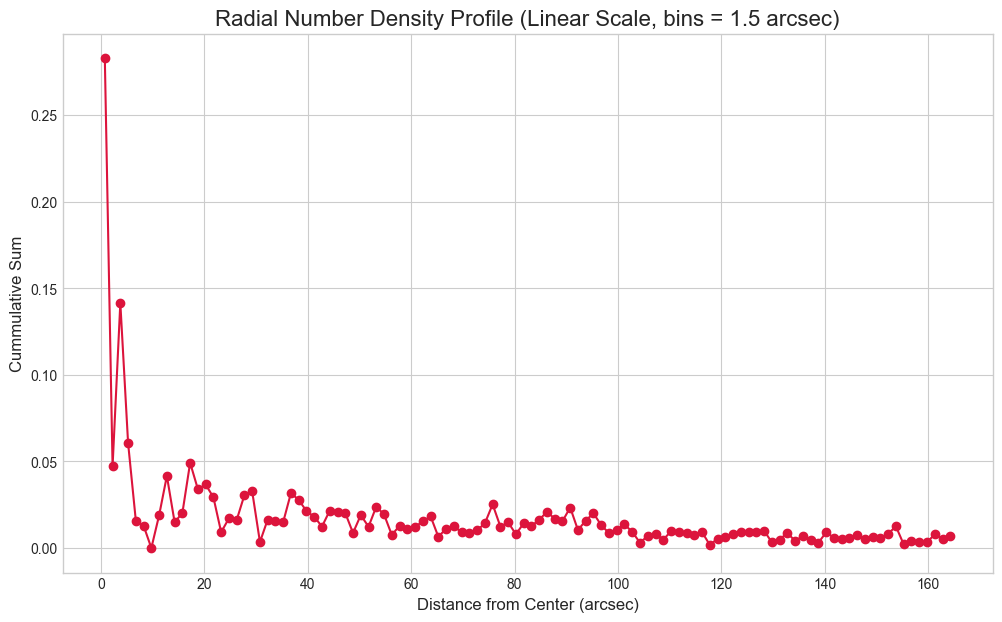

In [ ]:
plt.figure(figsize=(12, 7))

plt.plot(bin_centers_arcsec, number_density_arcsec, 'o-', color='crimson')

plt.title(f'Radial Number Density Profile (Linear Scale, bins = {bin_width_arcsec:.1f} arcsec)', fontsize=16)
plt.xlabel(r'Distance from Center (arcsec)', fontsize=12)
plt.ylabel(r'Number Density (N / arcsec$^2$)', fontsize=12)

plt.show()

In [36]:
temp_lis = number_density_arcsec[20:]
temp_lis = np.array(temp_lis)
mean = np.mean(temp_lis)
print(mean)


0.011168953847422634


In [37]:
main_lis = number_density_arcsec[:20]
main_lis = np.array(main_lis)
main_lis = main_lis - mean
main_lis

array([ 0.27177317,  0.03598807,  0.13030211,  0.0494615 ,  0.00455005,
        0.00169205, -0.01116895,  0.00769385,  0.03044018,  0.00372274,
        0.0090412 ,  0.03803837,  0.0227841 ,  0.02550873,  0.01810092,
       -0.00204179,  0.00597905,  0.00499917,  0.01941938,  0.02147821])

Text(0, 0.5, 'Number Density (N / arcsec$^2$)')

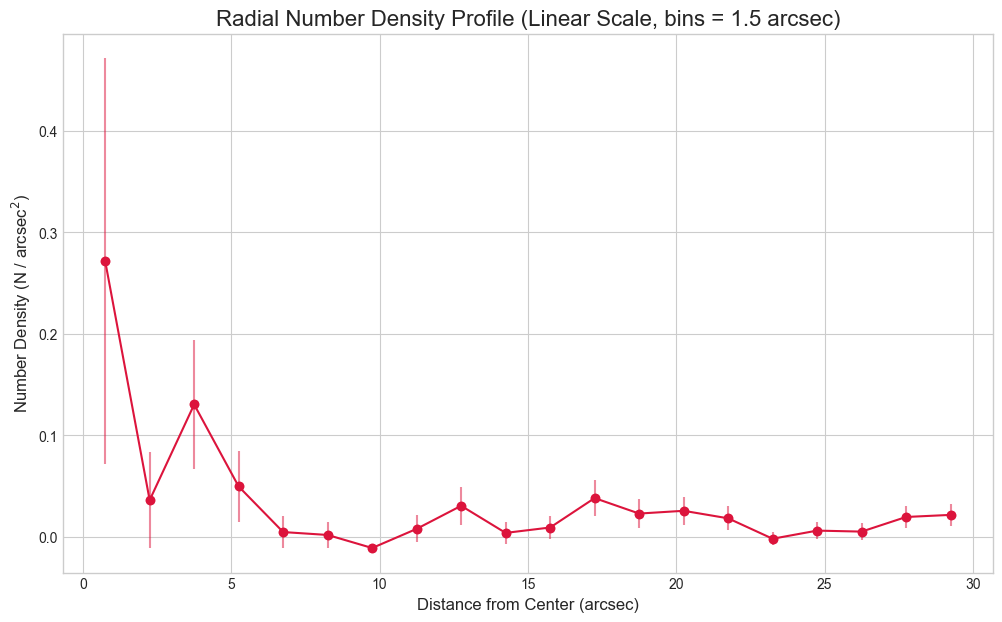

In [38]:
plt.figure(figsize=(12, 7))

plt.plot(bin_centers_arcsec[:20], main_lis, 'o-', color='crimson')
plt.errorbar(bin_centers_arcsec[:20], main_lis, yerr=np.sqrt(counts[:20])/ring_areas_pixels2[:20]/area_conversion_factor, fmt='o', color='crimson', alpha=0.5)

plt.title(f'Radial Number Density Profile (Linear Scale, bins = {bin_width_arcsec:.1f} arcsec)', fontsize=16)
plt.xlabel(r'Distance from Center (arcsec)', fontsize=12)
plt.ylabel(r'Number Density (N / arcsec$^2$)', fontsize=12)

In [39]:
distances_kpc_refined = scale * main_lis
print(distances_kpc_refined)
bin_arcsec_refined = bin_centers_arcsec[:20]* scale
print(bin_arcsec_refined)
type(distances_kpc_refined), type(bin_arcsec_refined)

[ 0.13596605  0.01800456  0.06518915  0.02474521  0.00227636  0.00084652
 -0.00558774  0.00384918  0.01522899  0.00186246  0.00452324  0.01903031
  0.01139871  0.01276182  0.00905575 -0.00102149  0.00299127  0.00250105
  0.00971537  0.01074539]
[ 0.37521929  1.12565788  1.87609646  2.62653505  3.37697363  4.12741221
  4.8778508   5.62828938  6.37872797  7.12916655  7.87960514  8.63004372
  9.3804823  10.13092089 10.88135947 11.63179806 12.38223664 13.13267523
 13.88311381 14.63355239]


(numpy.ndarray, numpy.ndarray)

Text(0, 0.5, 'Number Density (N / kpc$^2$)')

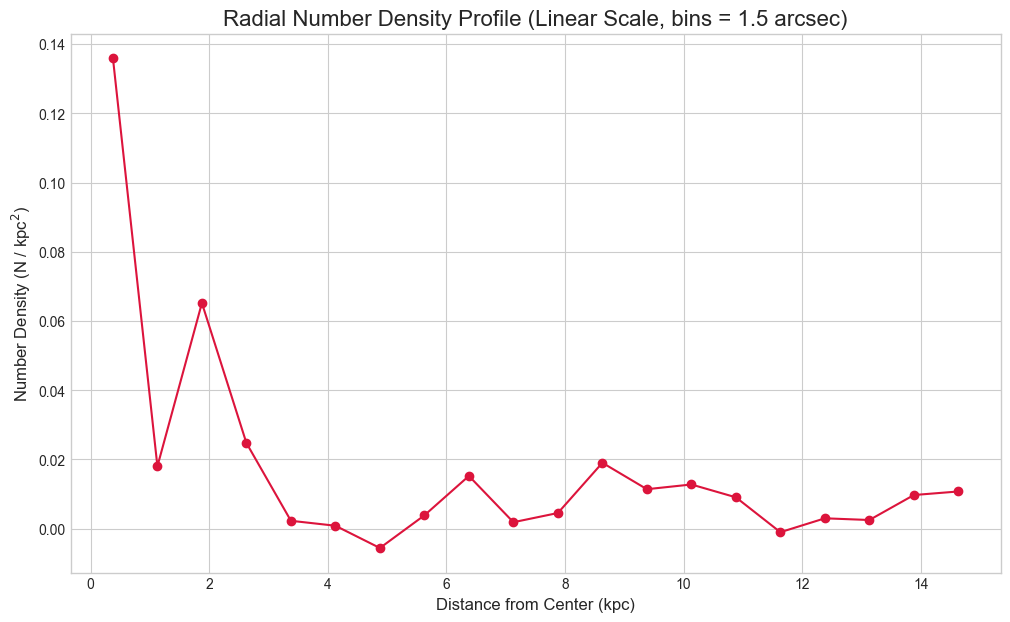

In [40]:
plt.figure(figsize=(12, 7))

plt.plot(bin_arcsec_refined, distances_kpc_refined, 'o-', color='crimson')

plt.title(f'Radial Number Density Profile (Linear Scale, bins = {bin_width_arcsec:.1f} arcsec)', fontsize=16)
plt.xlabel(r'Distance from Center (kpc)', fontsize=12)
plt.ylabel(r'Number Density (N / kpc$^2$)', fontsize=12)

In [41]:
GC = 0

templen = int(len(distances_kpc_refined))
print(templen)
for i in range(templen):
    a = distances_kpc_refined[i]
    if i == 0:
        b = 0
        c = bin_arcsec_refined[i]
    else:
        b = bin_arcsec_refined[i-1]
        c = bin_arcsec_refined[i]
    area = np.pi *(c**2 - b**2)
    GC = GC + a*area

print(GC)


20
5.3893544358488095
